# Workshop: Structural Health Monitoring (SHM) with ML

**Objective:**
Learn how to detect damage in a structure (like a bridge or building) using data, even when environmental conditions (like temperature) are changing.

**The Challenge:**
1.  **Structures change:** Materials get softer when hot and stiffer when cold. This changes the structure's natural frequencies.
2.  **Damage changes:** Cracks or corrosion also change natural frequencies.
3.  **The Problem:** How do we distinguish between a hot day and a broken beam?

**The Solution:**
Model the effect of environmental changes on the structure and if the model cannot explain the changes, we suspect damage. 
but what if you don't have the environmental measurements (temperature )?


---
**Agenda:**
1.  **The Physics:** Simulate a 3-mass system (like a 3-story building).
2.  **The Environment:** Simulate a 2-week monitoring campaign with temperature cycles.
3.  **The Damage:** Introduce a "crack" (stiffness loss) halfway through.
4.  **The ML:** Use PCA to filter out temperature and detect the damage.
5.  **The Extension:** Try other regression models to improve damage detection. and use PCA to see how good can we do without temperature data.

### Instructions for Students
In this notebook, you will find several **Exercises**.
You need to implement the missing code in the functions provided.
Look for the comments describing what to do.

The solutions are marked with:
```python
### BEGIN SOLUTION
...
### END SOLUTION
```
Try to implement the code yourself before looking at the solution!

## 1. The Physical System
Imagine a simple 4-story building. We model it as 4 masses connected by springs.
*   **Masses ($m$):** The floors.
*   **Springs ($k$):** The columns.

We want to find the **Natural Frequencies** of this building. These are the "musical notes" the building plays when it vibrates.
$$ [M] \ddot{u} + [K] u = 0 \implies \det([K] - \omega^2 [M]) = 0 $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- 1. Define the Building ---
m1, m2, m3, m4 = 1.0, 2.0, 3.0, 4.0       # Masses (kg)
k1, k2, k3, k4 = 1000.0, 1500.0, 500.0, 2000.0 # Stiffness (N/m) at 0°C

def get_system_matrices(k1, k2, k3, k4):
    """Creates Mass (M) and Stiffness (K) matrices."""
    M = np.diag([m1, m2, m3, m4])
    K = np.array([
        [k1 + k2, -k2, 0, 0],
        [-k2, k2 + k3, -k3, 0],
        [0, -k3, k3 + k4, -k4],
        [0, 0, -k4, k4]
    ])
    return M, K

def get_natural_frequencies(K, M):
    """Calculates the resonance frequencies (Hz)."""
    # Exercise: Calculate the natural frequencies
    # 1. Solve the generalized eigenvalue problem: (K - w^2 M)v = 0
    #    Use scipy.linalg.eigh(K, M) to get eigenvalues (w^2)
    # 2. Convert eigenvalues to frequencies in Hz: f = sqrt(w^2) / (2*pi)
    
    ### BEGIN SOLUTION
    evals, _ = eigh(K, M)
    return np.sqrt(evals) / (2 * np.pi)
    ### END SOLUTION

In [2]:
# --- 2. Check the "Healthy" State ---
M, K_ref = get_system_matrices(k1, k2, k3, k4)
freqs_ref = get_natural_frequencies(K_ref, M)

print(f"Building Natural Frequencies (at 0°C):")
for i, f in enumerate(freqs_ref):
    print(f"Mode {i+1}: {f:.2f} Hz")

Building Natural Frequencies (at 0°C):
Mode 1: 0.94 Hz
Mode 2: 3.40 Hz
Mode 3: 5.72 Hz
Mode 4: 8.79 Hz


In [3]:
def simulate_vibration(M, K, duration=10):
    """Simulates the building vibrating under random load."""
    # Define Damping (Rayleigh)
    alpha, beta = 0.5, 0.0001
    C = alpha * M + beta * K

    # State Space Model Construction
    n_dof = 4
    Minv = np.linalg.inv(M)
    A = np.vstack([
        np.hstack([np.zeros((n_dof, n_dof)), np.eye(n_dof)]),
        np.hstack([-Minv @ K, -Minv @ C])
    ])
    B = np.vstack([np.zeros((n_dof, 1)), Minv @ np.array([[1], [0], [0], [0]])]) # Force on Mass 1
    C_out = np.zeros((1, 2*n_dof)); C_out[0, 3] = 1 # Measure Mass 4 (Top Floor)
    sys = signal.StateSpace(A, B, C_out, np.zeros((1, 1)))

    # Simulate
    t = np.linspace(0, duration, 1000)
    u_input = np.random.normal(0, 10, len(t)) # Random wind/traffic load
    _, y, _ = signal.lsim(sys, u_input, t)
    return t, y.flatten()

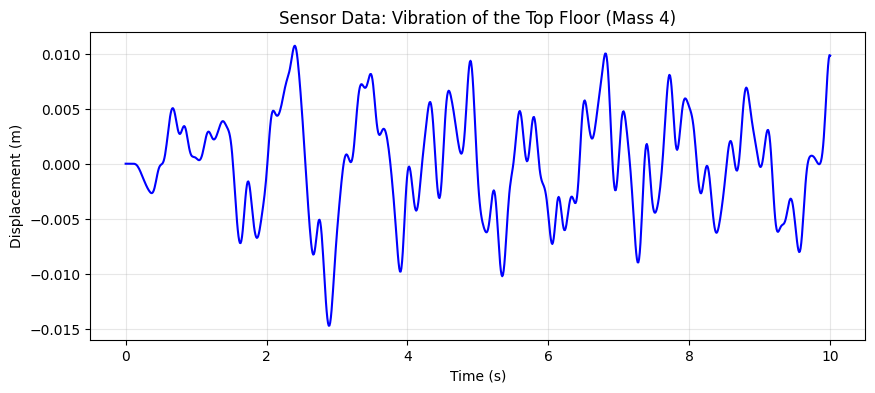

In [39]:
# --- 3. Visualize the Response ---
t, y = simulate_vibration(M, K_ref)

plt.figure(figsize=(10, 4))
plt.plot(t, y, 'b')
plt.title("Sensor Data: Vibration of the Top Floor (Mass 4)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.grid(True, alpha=0.3)
plt.show()

## 2. The Environment (Temperature)
Real structures are exposed to the sun.
*   **Hot day:** Material softens -> Frequencies go **DOWN**.
*   **Cold night:** Material stiffens -> Frequencies go **UP**.

We simulate a **2-week monitoring campaign** where temperature fluctuates day and night.

In [5]:
def generate_temperature_profile(n_weeks=2):
    """Generates a realistic temperature profile."""
    hours = np.arange(0, n_weeks*24) 
    np.random.seed(42)
    # Daily cycle (24h) + Weekly trend + Random noise
    temp = 15 + 10*np.sin(2*np.pi*hours/24 - np.pi/2) + 10*np.sin(2*np.pi*hours/(24*7)) + np.random.normal(0, 2, len(hours))
    return hours, temp

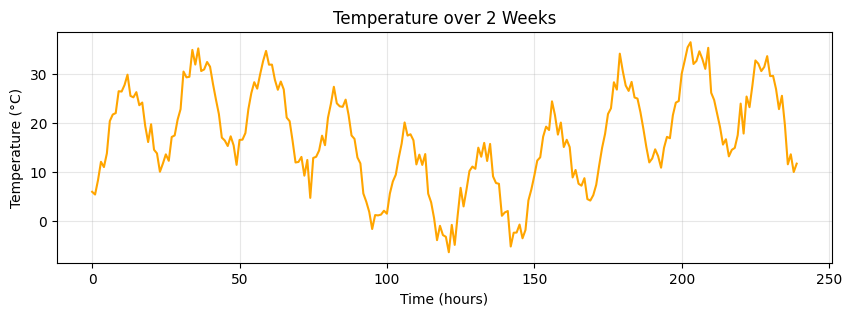

In [6]:
# --- Simulate Temperature ---
hours, temp = generate_temperature_profile(10)

plt.figure(figsize=(10, 3))
plt.plot(hours, temp, color='orange')
plt.title("Temperature over 2 Weeks")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.grid(True, alpha=0.3)
plt.show()

## 3. The Monitoring Campaign (Healthy vs Damaged)
Now we simulate the frequencies we would measure every hour.
*   **First week (0-168h):** Healthy.
*   **Second week (168h+):** **DAMAGE!** Spring 3 loses 5% stiffness.

Notice in the plots below: **Can you easily see the damage?**
It's hard because the temperature makes the frequency wiggle up and down much more than the damage does!

In [7]:
def apply_temperature_effect(k, T, alpha=0.005):
    """Reduces stiffness as temperature increases."""
    # Exercise: Implement the temperature effect on stiffness
    # Hint: Stiffness decreases linearly with temperature: k_new = k * (1 - alpha * T)
    
    ### BEGIN SOLUTION
    return k * (1 - alpha * T)
    ### END SOLUTION

def apply_damage(k, damage_factor):
    """Reduces stiffness by a factor (e.g., 0.05 for 5% loss)."""
    # Exercise: Implement the damage effect on stiffness
    # Hint: Stiffness decreases by the damage factor: k_new = k * (1 - damage_factor)
    
    ### BEGIN SOLUTION
    return k * (1 - damage_factor)
    ### END SOLUTION

In [8]:
def run_monitoring_campaign(temp, damage_time, damage_amount):
    """Simulates the monitoring campaign."""
    measured_freqs = []
    
    for h, T in enumerate(temp):
        # 1. Apply Temperature
        k1_t = apply_temperature_effect(k1, T, alpha=0.005)
        k2_t = apply_temperature_effect(k2, T, alpha=-0.05)
        k3_t = apply_temperature_effect(k3, T, alpha=-0.007)
        k4_t = apply_temperature_effect(k4, T, alpha=-0.01) # Added k4 effect
        
        # 2. Apply Damage (if applicable)
        if h >= damage_time:
            k2_t = apply_damage(k2_t, damage_amount)
            
        # 3. Calculate Frequencies
        _, K_t = get_system_matrices(k1_t, k2_t, k3_t, k4_t)
        f = get_natural_frequencies(K_t, M)
        
        # 4. Add Noise
        f += np.random.normal(0, 0.005, 4) # 4 modes
        measured_freqs.append(f)
        
    return np.array(measured_freqs)

In [9]:
# --- Run Simulation ---
damage_time = 168 # Damage happens after 1 week
damage_amount = 0.1 # 5% stiffness loss

measured_freqs = run_monitoring_campaign(temp, damage_time, damage_amount)

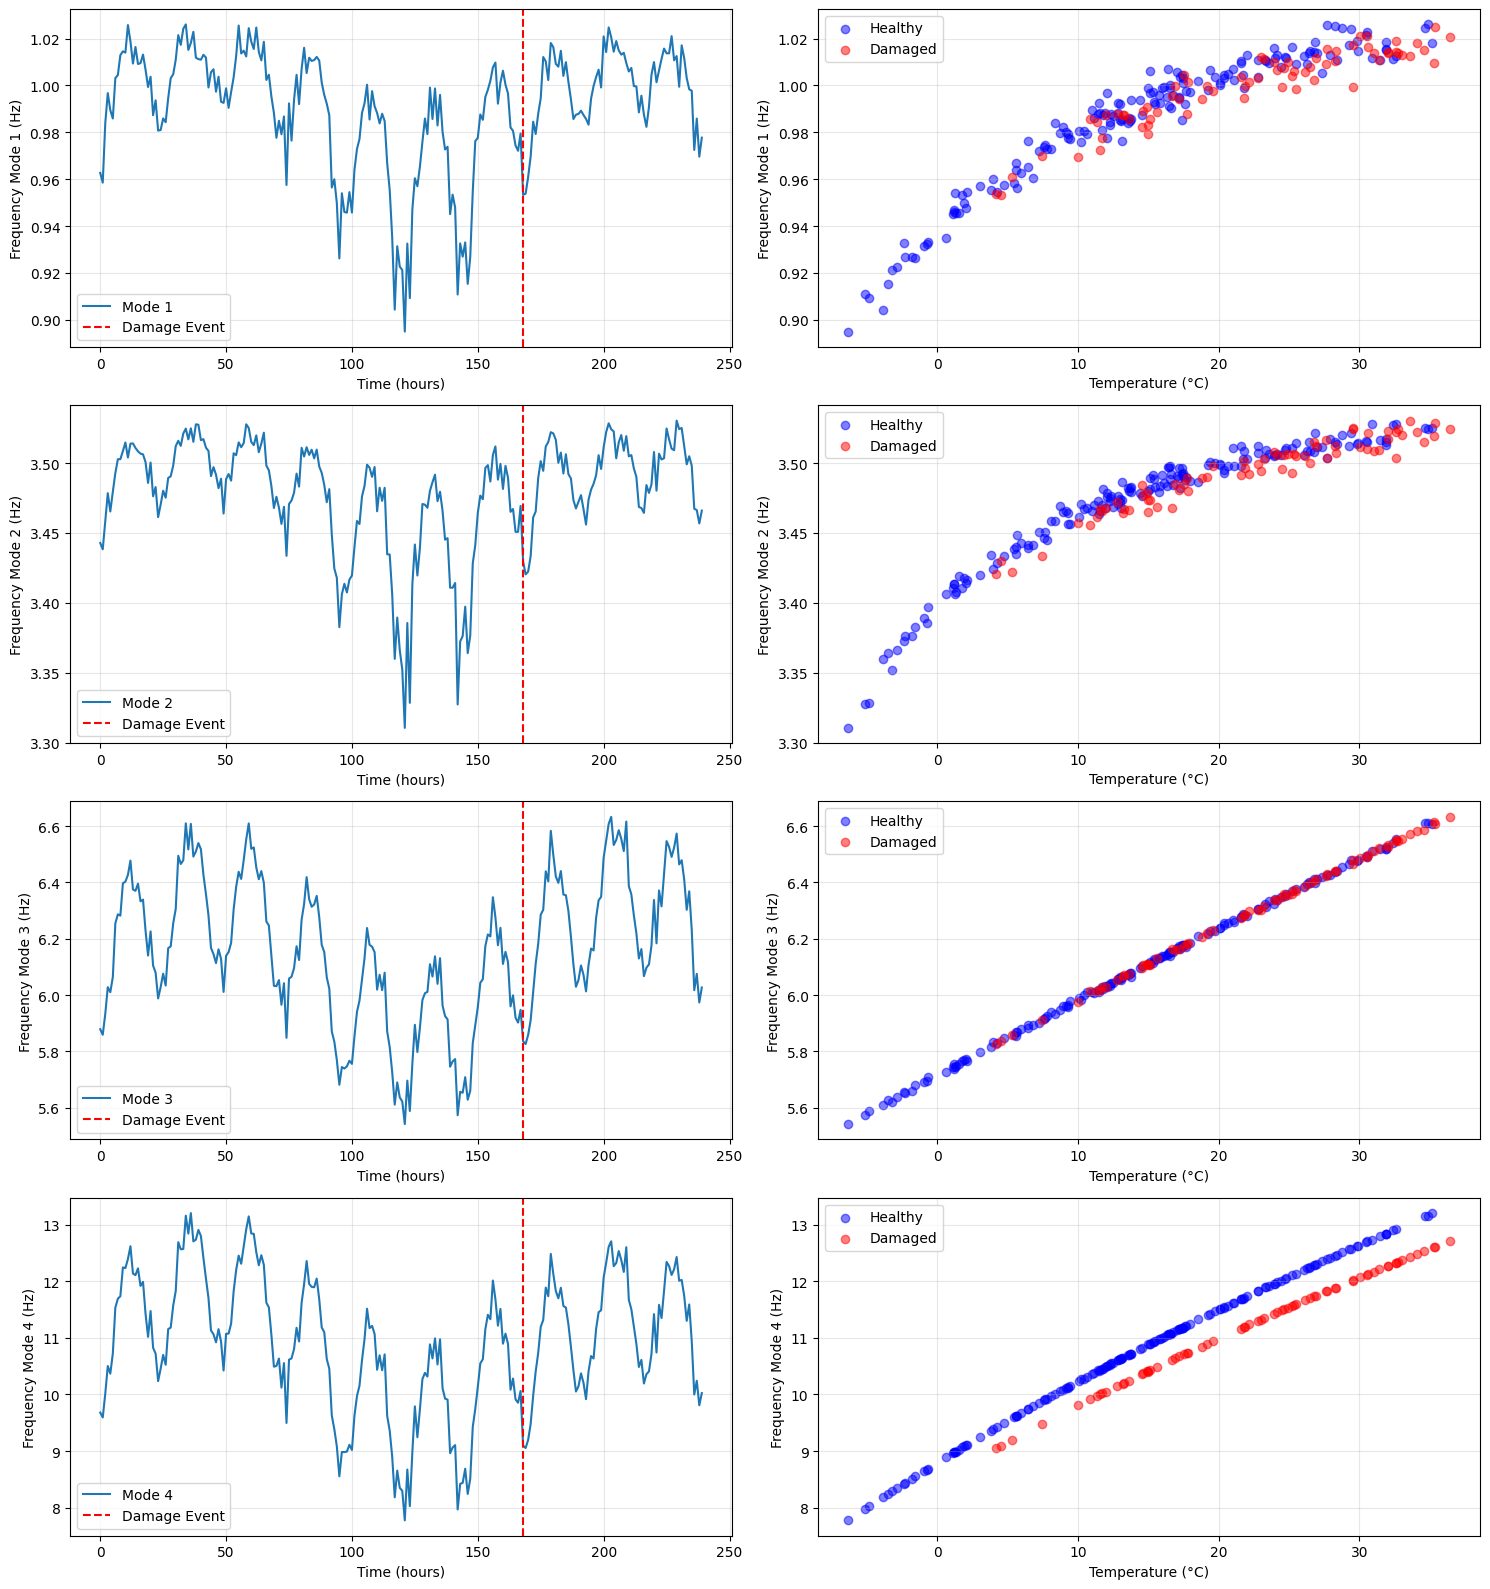

In [10]:
# --- Plotting Results ---
fig, axes = plt.subplots(4, 2, figsize=(15, 16))

for mode in range(4):
    # Time Series
    ax_time = axes[mode, 0]
    ax_time.plot(hours, measured_freqs[:, mode], label=f'Mode {mode+1}')
    ax_time.axvline(damage_time, color='r', linestyle='--', label='Damage Event')
    ax_time.set_ylabel(f"Frequency Mode {mode+1} (Hz)")
    ax_time.set_xlabel("Time (hours)")
    ax_time.legend()
    ax_time.grid(True, alpha=0.3)

    # Temp vs Freq
    ax_temp = axes[mode, 1]
    mask_healthy = hours < damage_time
    ax_temp.scatter(temp[mask_healthy], measured_freqs[mask_healthy, mode], c='blue', alpha=0.5, label='Healthy')
    ax_temp.scatter(temp[~mask_healthy], measured_freqs[~mask_healthy, mode], c='red', alpha=0.5, label='Damaged')
    ax_temp.set_ylabel(f"Frequency Mode {mode+1} (Hz)")
    ax_temp.set_xlabel("Temperature (°C)")
    ax_temp.legend()
    ax_temp.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Questions
- which mode shows the most significant change after damage occurs? 
- looking at the raw frequency data, can you tell when the damage happened? without knowing the temperature effect? in a real scenario there is not vertical line to indicate damage time.

## 4. Solution 1: Regression-based Compensation
The simplest way to remove the temperature effect is to **predict** it.
We assume: $Frequency = f(Temperature)$

1.  **Train:** Learn this relationship using healthy data (Week 1).
2.  **Predict:** Estimate what the frequency *should* be for the current temperature.
3.  **Residual:** Calculate the difference ($Measured - Predicted$).

If the residual is large, it means the frequency has changed due to something else... **DAMAGE!**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Random Forest Regressor is nice because it can capture non-linear relationships without much tuning. 
# easy to implement 

def train_regression_model(temp_train, freq_train):
    """Trains a regression model: Freq = f(Temp)"""
    # Exercise: Initialize and train a Random Forest Regressor
    # 1. Initialize the model (e.g., RandomForestRegressor with n_estimators=10)
    # 2. Reshape temp_train to be 2D array: (n_samples, 1)
    # 3. Fit the model to the data
    
    ### BEGIN SOLUTION
    model = RandomForestRegressor(n_estimators=10)
    # Reshape for sklearn (n_samples, n_features)
    X = temp_train.reshape(-1, 1)
    y = freq_train
    model.fit(X, y)
    return model
    ### END SOLUTION
    
    

In [ ]:
# Implement another regression model on your own  look at the sklearn documentation for ideas. 

In [12]:
# 1. Prepare Data (Use All Modes)
train_mask = hours < damage_time -24
temp_train = temp[train_mask]
freq_train = measured_freqs[train_mask, :] # Use all 4 modes

# 2. Train Model
reg_model = train_regression_model(temp_train, freq_train)

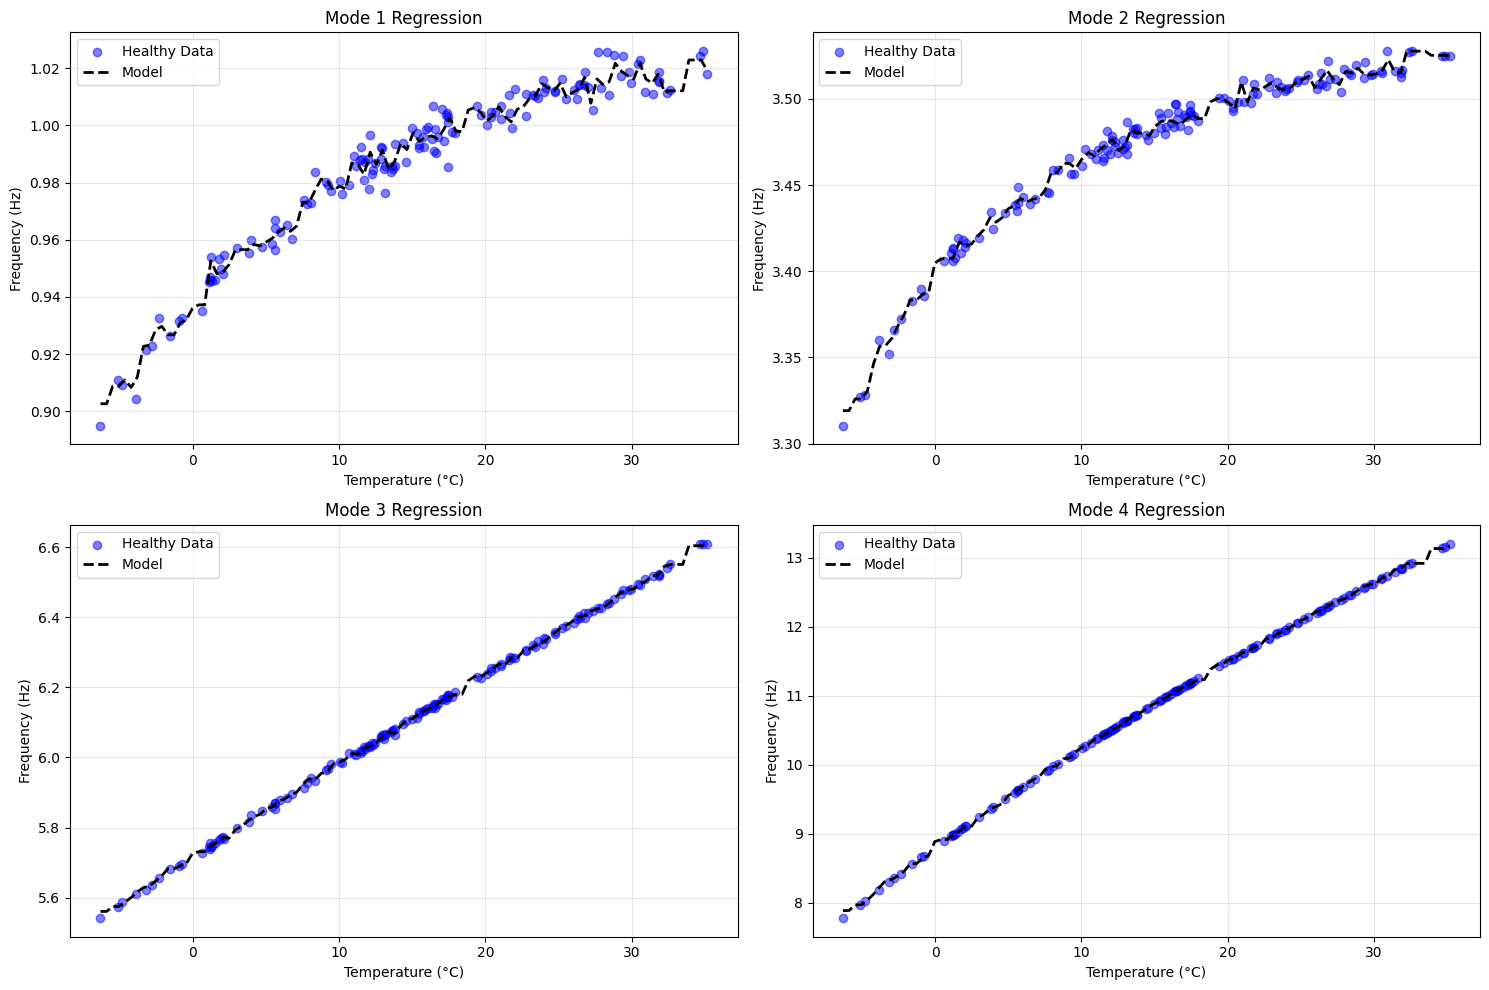

In [13]:
# --- Visualize Regression ---
T_range = np.linspace(temp_train.min(), temp_train.max(), 100).reshape(-1, 1)
f_pred_range = reg_model.predict(T_range)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    ax.scatter(temp_train, freq_train[:, i], color='blue', alpha=0.5, label='Healthy Data')
    ax.plot(T_range, f_pred_range[:, i], color='k', linestyle='--', linewidth=2, label='Model')
    
    ax.set_title(f"Mode {i+1} Regression")
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Frequency (Hz)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
def calculate_residuals(temp_all, freq_all, model):
    """Calculates prediction errors (residuals)."""
    # Exercise: Calculate the residuals
    # 1. Reshape temp_all to (n_samples, 1)
    # 2. Predict frequencies using the model
    # 3. Calculate residuals: Measured - Predicted
    
    ### BEGIN SOLUTION
    X_all = temp_all.reshape(-1, 1)
    freq_pred = model.predict(X_all)
    return freq_all - freq_pred
    ### END SOLUTION

In [15]:
# 1. Predict for ALL data
residuals_reg = calculate_residuals(temp, measured_freqs, reg_model)

# 2. Define Thresholds (3 standard deviations of healthy residuals for each mode)
thresholds_reg = 3 * np.std(residuals_reg[train_mask], axis=0)

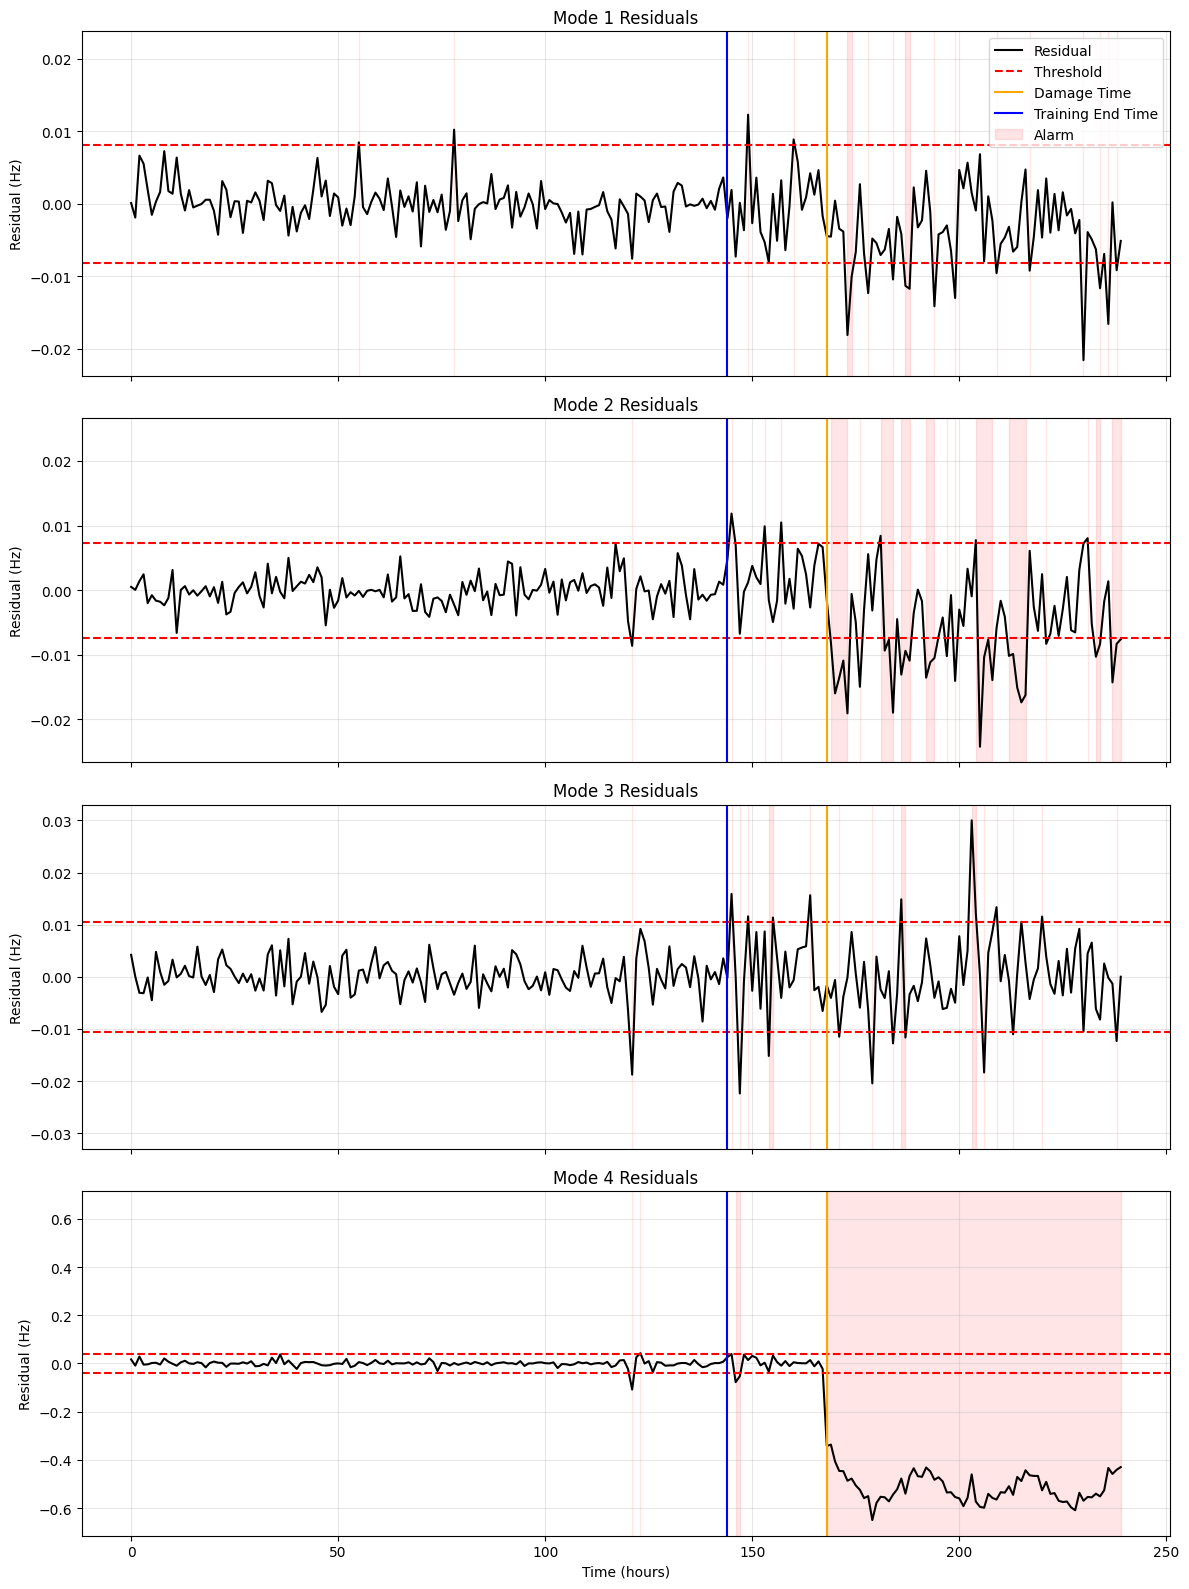

In [16]:
# --- Plot Residuals ---
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

for i in range(4):
    ax = axes[i]
    ax.plot(hours, residuals_reg[:, i], 'k', label='Residual')
    
    # Thresholds
    thresh = thresholds_reg[i]
    ax.axhline(thresh, color='r', linestyle='--', label='Threshold')
    ax.axhline(-thresh, color='r', linestyle='--')
    
    ax.axvline(damage_time, color='orange', linestyle='-', label='Damage Time')
    ax.axvline(damage_time -24, color='blue', linestyle='-', label='Training End Time')
    
    # Highlight damage
    alarm_mask = np.abs(residuals_reg[:, i]) > thresh
    # Use a fixed y-range for fill or dynamic based on data
    y_lim = max(np.max(np.abs(residuals_reg[:, i])), thresh) * 1.1
    ax.fill_between(hours, -y_lim, y_lim, where=alarm_mask, color='red', alpha=0.1, label='Alarm')
    ax.set_ylim(-y_lim, y_lim)

    ax.set_title(f"Mode {i+1} Residuals")
    ax.set_ylabel("Residual (Hz)")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(loc='upper right')

axes[-1].set_xlabel("Time (hours)")
plt.tight_layout()
plt.show()

## 5. Solution 2: PCA (Principal Component Analysis)
Regression works great for 1 variable (Temperature). But what if we have Humidity, Wind, Traffic, etc.?
**PCA** is a more general method. It finds "patterns" in the data.

*   **PC1, PC2:** Captures the dominant pattern (Temperature Effect).
*   **PC3...:** Capture the noise... and the **Damage**!



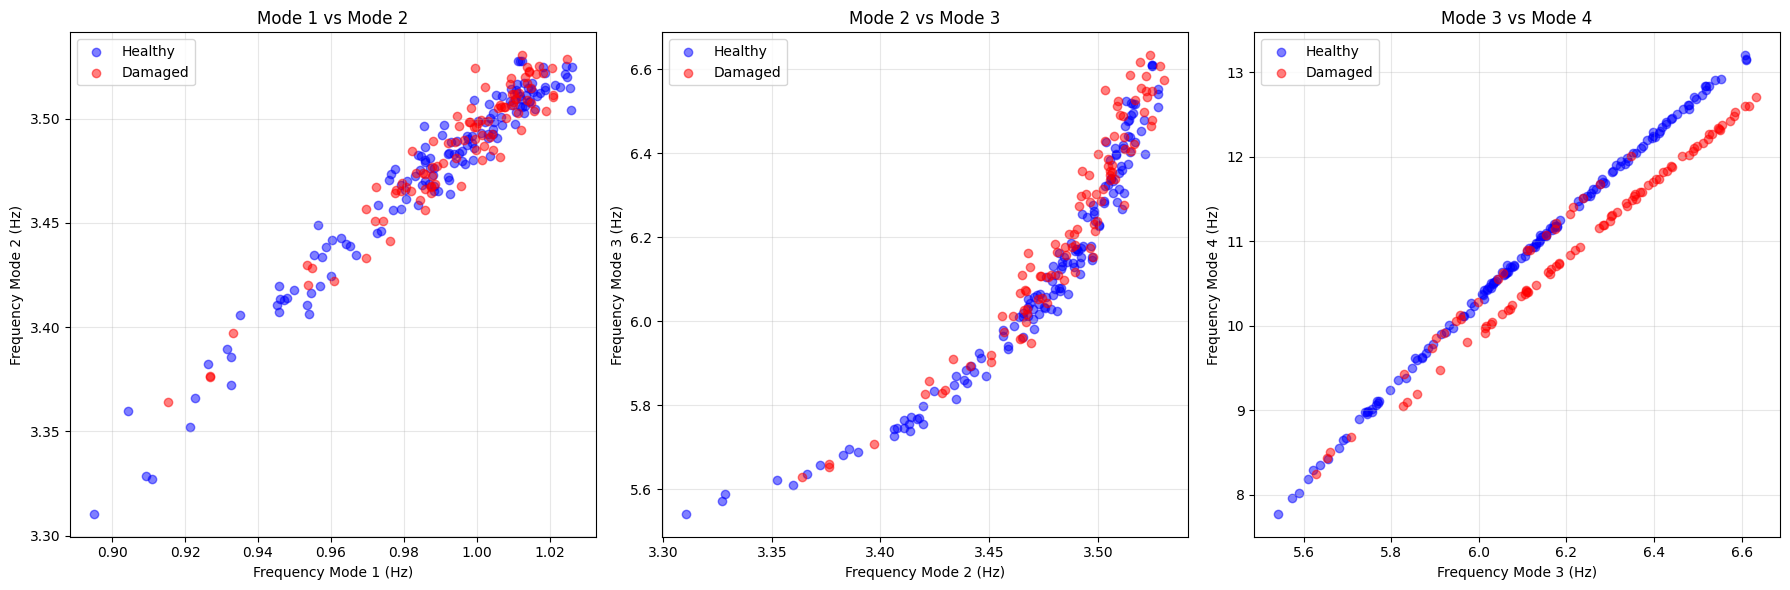

In [17]:
import seaborn as sns

# Pairwise scatter plots of resonance frequencies
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pairs to plot: (Mode 1 vs Mode 2), (Mode 2 vs Mode 3), (Mode 3 vs Mode 4)
pairs = [(0, 1), (1, 2), (2, 3)]

for i, (m1, m2) in enumerate(pairs):
    ax = axes[i]
    ax.scatter(measured_freqs[train_mask, m1], measured_freqs[train_mask, m2], c='blue', alpha=0.5, label='Healthy')
    ax.scatter(measured_freqs[~train_mask, m1], measured_freqs[~train_mask, m2], c='red', alpha=0.5, label='Damaged')
    ax.set_xlabel(f"Frequency Mode {m1+1} (Hz)")
    ax.set_ylabel(f"Frequency Mode {m2+1} (Hz)")
    ax.set_title(f"Mode {m1+1} vs Mode {m2+1}")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## question 
can we tell the different between blue and red point (healthy vs damage) point with only using how different frequnect varies with each other? 

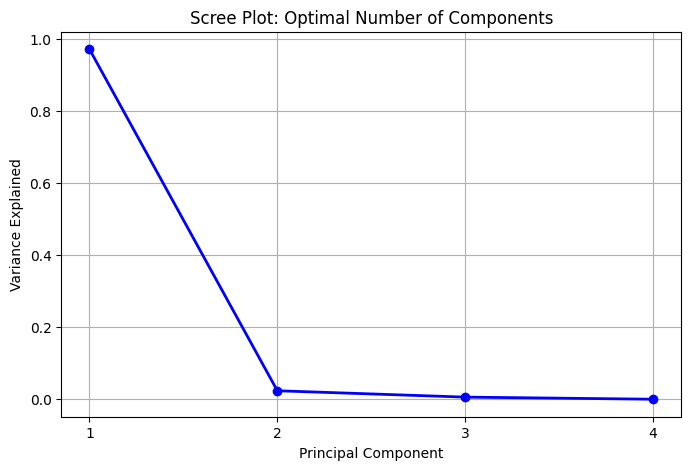

PC1 explains 97.0% of the variance.
PC2 explains 2.4% of the variance.
PC3 explains 0.6% of the variance.
PC4 explains 0.0% of the variance.


In [18]:
# Let's perform PCA to find the optimal number of components
# We look at the "Scree Plot" to see how much variance each component explains.
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_train_std = scaler.fit_transform(measured_freqs[train_mask])

pca = PCA()
pca.fit(X_train_std)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 5), pca.explained_variance_ratio_, 'bo-', linewidth=2, label='Explained Variance Ratio')
plt.title("Scree Plot: Optimal Number of Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.xticks([1, 2, 3, 4])
plt.grid(True)
plt.show()

for i in range(4):
    print(f"PC{i+1} explains {pca.explained_variance_ratio_[i]*100:.1f}% of the variance.")

In [19]:
import plotly.graph_objects as go
import numpy as np

# 1. Standardize ALL data (using the scaler fitted on healthy data)
X_all_std = scaler.transform(measured_freqs)

# 2. Create Traces
data = []

# Healthy Data
data.append(go.Scatter3d(
    x=X_all_std[train_mask, 0],
    y=X_all_std[train_mask, 1],
    z=X_all_std[train_mask, 2],
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.2),
    name='Healthy'
))

# Damaged Data
data.append(go.Scatter3d(
    x=X_all_std[~train_mask, 0],
    y=X_all_std[~train_mask, 1],
    z=X_all_std[~train_mask, 2],
    mode='markers',
    marker=dict(size=3, color='red', opacity=0.2),
    name='Damaged'
))

# 3. Add PC Axes (First 3 components)
scale = 3
origin = np.zeros(3)

for i, comp in enumerate(pca.components_[:3]): # Only plot first 3 PCs
    # Vector end point (projected onto first 3 dimensions)
    end = origin + comp[:3] * scale
    
    # Line for the vector
    data.append(go.Scatter3d(
        x=[origin[0], end[0]],
        y=[origin[1], end[1]],
        z=[origin[2], end[2]],
        mode='lines+text',
        line=dict(color='black', width=5),
        text=["", f"PC{i+1}"],
        textposition="top center",
        textfont=dict(size=12, color='black'),
        name=f'PC{i+1}',
        showlegend=False
    ))
    
    # Cone for arrow head
    data.append(go.Cone(
        x=[end[0]], y=[end[1]], z=[end[2]],
        u=[comp[0]], v=[comp[1]], w=[comp[2]],
        sizemode="absolute", sizeref=0.2, anchor="tail",
        showscale=False, colorscale=[[0, 'black'], [1, 'black']],
        name=f'PC{i+1} Arrow',
        showlegend=False
    ))

# 4. Layout
layout = go.Layout(
    title='3D View: Standardized Frequencies (Modes 1-3) & PC Axes',
    scene=dict(
        xaxis_title='Std. Freq Mode 1',
        yaxis_title='Std. Freq Mode 2',
        zaxis_title='Std. Freq Mode 3',
        aspectmode='cube'
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(x=0.7, y=0.9)
)

fig = go.Figure(data=data, layout=layout)
fig.show()

# Q-statistic (Squared Prediction Error) Calculation for PCA and T-statistic Methods
The figure below shows a case where 2D point cloud is fitted with PCA having 1 principal component. The Q-statistic (Squared Prediction Error) is the squared distance from each point to its projection on the principal component line. while the T-statistic (Hotelling's T2) is the squared distance from the origin to the projection of each point on the principal component line. 
![Q-and-T-statistics](figures/qt_stat.png)

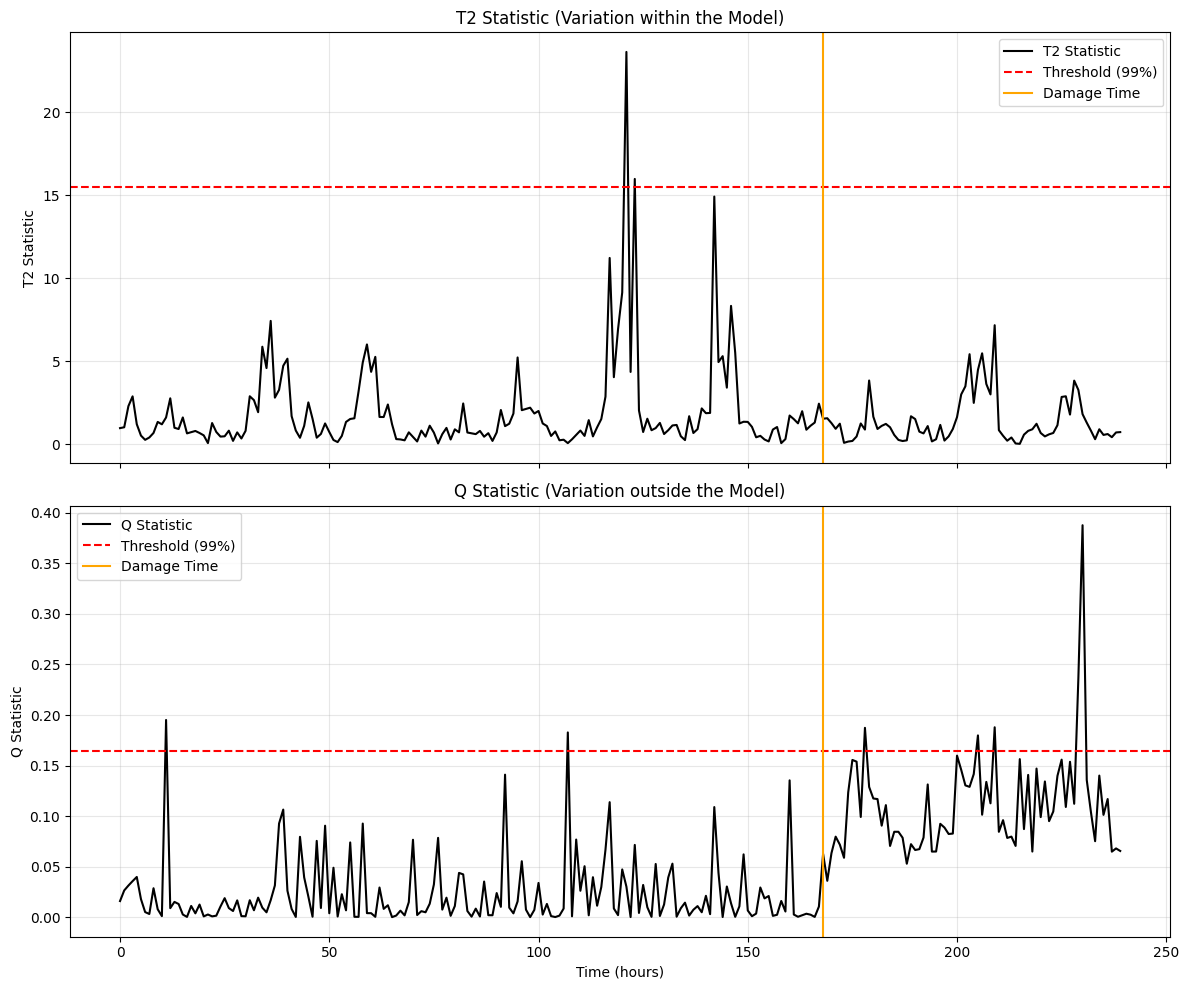

In [20]:
from sklearn.decomposition import PCA
from scipy.stats import f, chi2

# 1. Train PCA
pca_1 = PCA(n_components=2)
pca_1.fit(X_train_std)

# 2. Calculate Statistics
# Transform all data
scores = pca_1.transform(X_all_std)
X_reconstructed = pca_1.inverse_transform(scores)

# T2 Statistic (Mahalanobis Distance in PC space)
# T2 = sum(score^2 / eigenvalue)
T2_stats = np.sum(scores**2 / pca_1.explained_variance_, axis=1)

# Q Statistic (Squared Prediction Error / Residuals)
# Q = sum((original - reconstructed)^2)
residuals = X_all_std - X_reconstructed
Q_stats = np.sum(residuals**2, axis=1)

# 3. Calculate Thresholds (Empirical 99% from Training Data)
# We use the statistics from the healthy reference data (training set)
T2_thresh = np.percentile(T2_stats[train_mask], 99)
Q_thresh = np.percentile(Q_stats[train_mask], 99)

# 4. Plot Results
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot T2
axes[0].plot(hours, T2_stats, 'k', label='T2 Statistic')
axes[0].axhline(T2_thresh, color='r', linestyle='--', label='Threshold (99%)')
axes[0].axvline(damage_time, color='orange', label='Damage Time')
axes[0].set_ylabel('T2 Statistic')
axes[0].set_title('T2 Statistic (Variation within the Model)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Q
axes[1].plot(hours, Q_stats, 'k', label='Q Statistic')
axes[1].axhline(Q_thresh, color='r', linestyle='--', label='Threshold (99%)')
axes[1].axvline(damage_time, color='orange', label='Damage Time')
axes[1].set_ylabel('Q Statistic')
axes[1].set_xlabel('Time (hours)')
axes[1].set_title('Q Statistic (Variation outside the Model)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

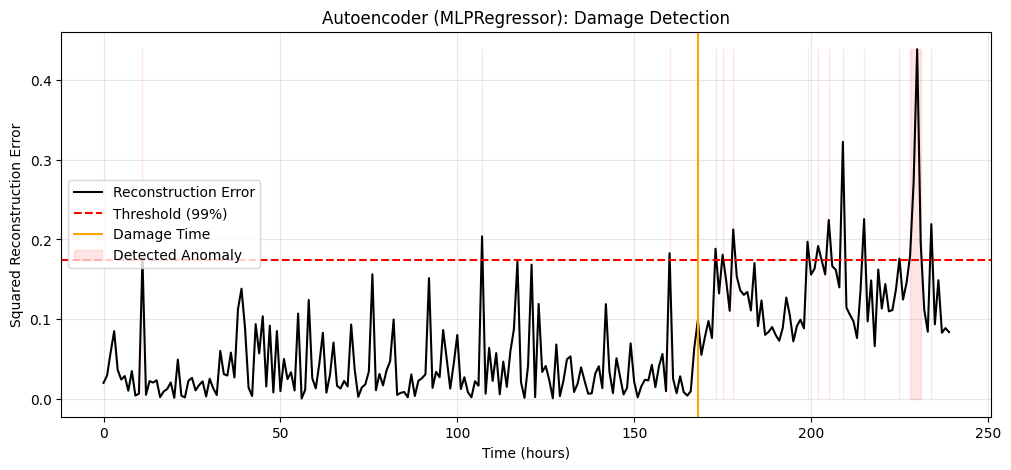

In [35]:
from sklearn.neural_network import MLPRegressor

# 1. Train Autoencoder
# We use MLPRegressor to map Input -> Input
# Structure: Input(3) -> Bottleneck(2) -> Output(3)
# This forces the network to learn a compressed representation (like PCA but non-linear)
autoencoder = MLPRegressor(hidden_layer_sizes=(512,64,8,64,128), 
                           activation='relu', 
                           solver='adam', 
                           max_iter=100000, 
                           random_state=42)

autoencoder.fit(X_train_std, X_train_std)

# 2. Calculate Reconstruction Error (Residuals)
X_reconstructed_ae = autoencoder.predict(X_all_std)
residuals_ae = X_all_std - X_reconstructed_ae
# Sum of squared errors (similar to Q-statistic)
Q_stats_ae = np.sum(residuals_ae**2, axis=1)

# 3. Calculate Threshold (Empirical 99% from Training Data)
Q_thresh_ae = np.percentile(Q_stats_ae[train_mask], 99)

# 4. Plot Results
plt.figure(figsize=(12, 5))
plt.plot(hours, Q_stats_ae, 'k', label='Reconstruction Error')
plt.axhline(Q_thresh_ae, color='r', linestyle='--', label='Threshold (99%)')
plt.axvline(damage_time, color='orange', label='Damage Time')

# Highlight damage region
plt.fill_between(hours, 0, np.max(Q_stats_ae), 
                 where=(Q_stats_ae > Q_thresh_ae), 
                 color='red', alpha=0.1, label='Detected Anomaly')

plt.ylabel('Squared Reconstruction Error')
plt.xlabel('Time (hours)')
plt.title('Autoencoder (MLPRegressor): Damage Detection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Question 
the anomaly is obviously detected however we have few point only triggering, what can we do to improve detection ?



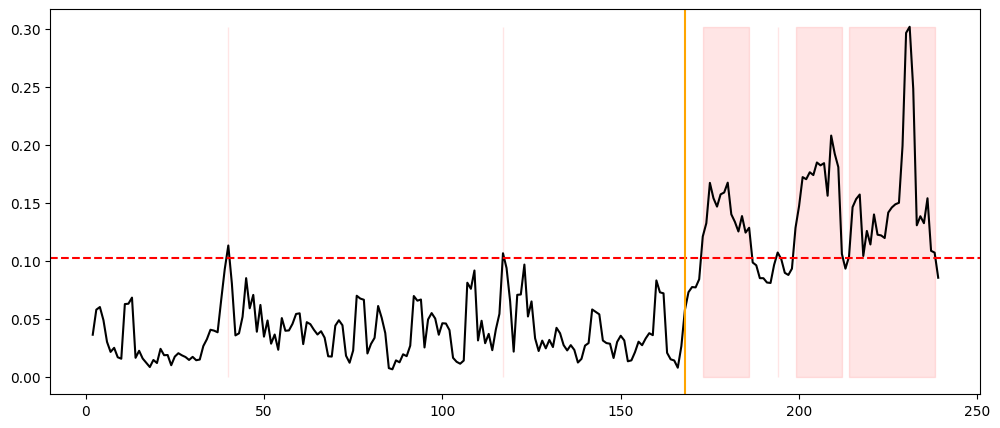

In [36]:
# Rolling Window Analysis 
window_size = 3
Q_stats_ae_windowed = np.convolve(Q_stats_ae, np.ones(window_size)/window_size, mode='valid')
Q_stats_ae_windowed_th = np.percentile(Q_stats_ae_windowed[train_mask[window_size-1:]], 99)
# Plot Results

plt.figure(figsize=(12, 5))
plt.plot(hours[window_size-1:], Q_stats_ae_windowed, 'k',
            label='Rolling Window Reconstruction Error')
plt.axhline(Q_stats_ae_windowed_th, color='r', linestyle='--', label='Threshold (99%)')
plt.axvline(damage_time, color='orange', label='Damage Time')
# Highlight damage region
plt.fill_between(hours[window_size-1:], 0, np.max(Q_stats_ae_windowed), 
                 where=(Q_stats_ae_windowed > Q_stats_ae_windowed_th), 
                 color='red', alpha=0.1, label='Detected Anomaly')